In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from statsmodels.api import OLS
import statsmodels.api as sm

In [2]:
df = pq.read_table("ibes-forecasts_collapsed-1.parquet").to_pandas()

In [3]:
df = df.dropna(subset=["surprise","surprise_lag"])

In [4]:
inf_mask = np.isinf(df["surprise_lag"])
df = df[~inf_mask]

In [6]:
#corona variable
df['year_month'] = df['fiscal_period_ending'].dt.to_period('M')
df['Covid'] = ((df['year_month'] > '2020-01') & (df['year_month'] <= '2021-01')).astype(int)

# Hypotheses:

#### 1. Hypothesis: Covid had an impact on analysts forecast accuarcy
#### 2. Hypothesis: The analyst accuarcy increases, the closer the annouce date of the firm
#### 3. Hypothesis: Analysts working at the biggest 10 % brokers by analyst count has a positive impact on PMAFE
#### 4. Hypothesis: Analysts forecast accuarcy decreases with the number of industries followed

---

In [7]:
#regression variables
variables = ["broker_coverage", "top_10", "broker_size", "analyst_following_jt", "analyst_portfolio_company_complexity_it", "analyst_portfolio_industry_complexity_it", "general_analyst_experience_log", "surprise_lag", "Covid", "mean_forecast_horizon_days"]

In [8]:
X = df.drop('pmafe', axis=1)
X = X[variables]
X = sm.add_constant(X) 
y = df['pmafe']

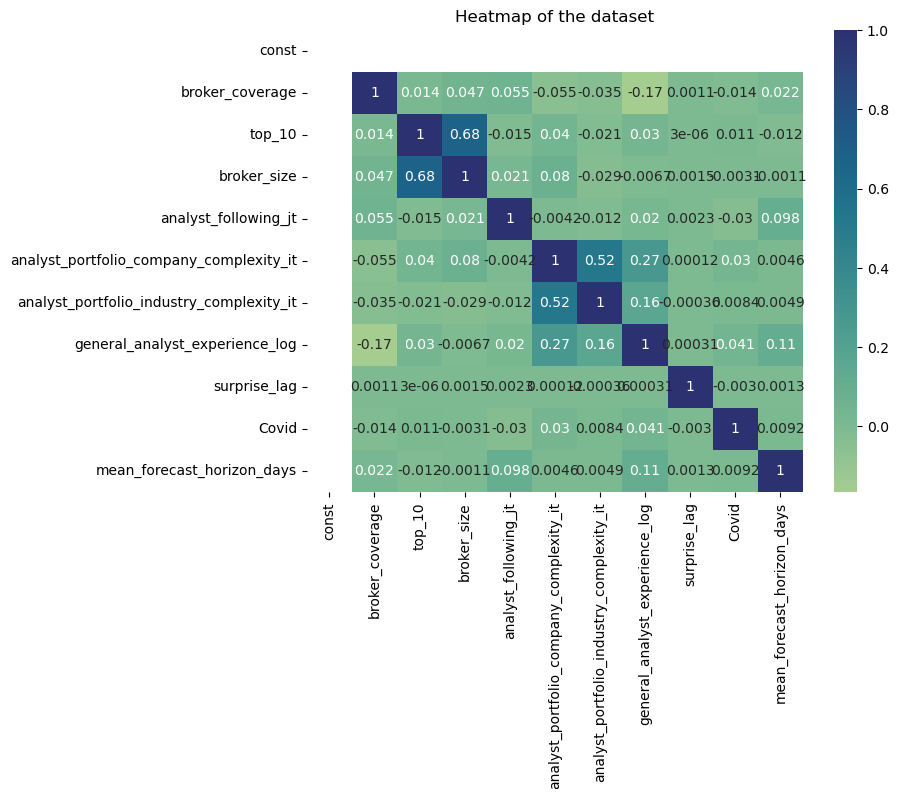

In [9]:
#correlation heatmap of some features
import seaborn as sns

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    X
    .corr(numeric_only=True), annot=True, cmap="crest"
)

plt.title("Heatmap of the dataset")
plt.show()

---
#### 1. Hypothesis: Does increased analyst coverage positively correlates with accuracy

$$
ACC_{i,j,t} = \alpha_0 + \alpha_1 BrokerCoverage_{i,j,t} + \alpha_2 Top10_{i,j,t} + \alpha_3 BrokerSize_{i,j,t} + \alpha_4 AnalystFollowing_{i,j,t} + \alpha_k X^k_{i,j,t} + \epsilon_{i,j,t}
$$

In [10]:
print(OLS(y, X[["const", "broker_coverage", "top_10", "broker_size", "analyst_following_jt", "general_analyst_experience_log"]]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     69.54
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           5.78e-73
Time:                        12:48:12   Log-Likelihood:            -5.0363e+05
No. Observations:              490056   AIC:                         1.007e+06
Df Residuals:                  490050   BIC:                         1.007e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

---
#### 2. Hypothesis: Does the breadth of industries or companies followed by analysts negatively influence the accuracy of their predictions?

$$
ACC_{i,j,t} = \alpha_0 + \alpha_1 PortCompanyComplexity_{i,j,t} + \alpha_2 PortIndustryComplexity_{i,j,t} + \alpha_k X^k_{i,j,t} + \epsilon_{i,j,t}
$$

In [11]:
print(OLS(y, X[["const", "analyst_portfolio_company_complexity_it", "analyst_portfolio_industry_complexity_it", "broker_size", "general_analyst_experience_log", "surprise_lag", "mean_forecast_horizon_days"]]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2432.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:48:12   Log-Likelihood:            -4.9780e+05
No. Observations:              490056   AIC:                         9.956e+05
Df Residuals:                  490050   BIC:                         9.957e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

---
#### 3. Hypothesis: Does the general experience of analysts positively affect their accuracy and does the degree of the surprise in the previous period matter​

$$
ACC_{i,j,t} = \alpha_0 + \alpha_1 ExpLog_{i,j,t} + \alpha_2 SurpriseLag_{i,j,t} + \alpha_k X^k_{i,j,t} + \epsilon_{i,j,t}
$$

In [12]:
print(OLS(y, X[["const", "general_analyst_experience_log", "surprise_lag", "broker_size", "analyst_portfolio_company_complexity_it", "analyst_portfolio_industry_complexity_it"]]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     333.6
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          2.66e-287
Time:                        12:48:12   Log-Likelihood:            -5.0314e+05
No. Observations:              490056   AIC:                         1.006e+06
Df Residuals:                  490051   BIC:                         1.006e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

---
#### 4. Hypothesis: Does the occurrence of Covid affect the accuracy of analysts' forecasts?​

$$
ACC_{i,j,t} = \alpha_0 + \alpha_1 Covid_{i,j,t} + \epsilon_{i,j,t}
$$

In [13]:
print(OLS(y, X[["const", "Covid"]]).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.354
Date:                Fri, 08 Mar 2024   Prob (F-statistic):              0.245
Time:                        12:48:12   Log-Likelihood:            -5.0381e+05
No. Observations:              490056   AIC:                         1.008e+06
Df Residuals:                  490054   BIC:                         1.008e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0105      0.001     10.476      0.0

---
#### Final Model

In [14]:
print(OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2793.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:48:12   Log-Likelihood:            -4.9692e+05
No. Observations:              490056   AIC:                         9.939e+05
Df Residuals:                  490050   BIC:                         9.939e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

---
#### Fixed Effects

In [15]:
# Perform mean aggregation
subset_df = X.copy(deep=True)
subset_df["analyst"] = df["analyst"]
subset_df["pmafe"] = y
mean_df = subset_df.groupby("analyst").mean()
demeaned_df = subset_df.set_index("analyst") - mean_df
demeaned_df_y = demeaned_df["pmafe"]
demeaned_df_X = demeaned_df.drop("pmafe", axis=1)

In [16]:
print(OLS(demeaned_df_y, demeaned_df_X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  pmafe   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5895.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:48:13   Log-Likelihood:            -4.5856e+05
No. Observations:              490056   AIC:                         9.171e+05
Df Residuals:                  490051   BIC:                         9.172e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

/Users/KaySimon_1/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


---
Lasso Regression

In [17]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.3)
lasso.fit(X,y)

data = {
    "Variables": X.columns,
    "Lasso Coefficients": lasso.coef_,
}

df_lasso = pd.DataFrame(data)
df_lasso

,Variables,Lasso Coefficients
0,const,0.000000e+00
1,broker_coverage,0.000000e+00
2,top_10,-0.000000e+00
3,broker_size,0.000000e+00
4,analyst_following_jt,-0.000000e+00
5,analyst_portfolio_company_complexity_it,0.000000e+00
6,analyst_portfolio_industry_complexity_it,0.000000e+00
7,general_analyst_experience_log,-0.000000e+00
8,surprise_lag,-9.080356e-19
9,Covid,-0.000000e+00
